<h1>🌊 LaVague: Introduction to Web Agents with World Models</h1>

*Note 11th May 2024*:

This is a temporary notebook for users to play with our latest features to develop **Web Agents** using LaVague ([https://github.com/lavague-ai/LaVague](https://github.com/lavague-ai/LaVague)), our AI Web Agent framework using Large Action Models.

Proper documentation is coming soon, and will be available on our [docs](https://docs.lavague.ai/en/latest/).

# Installation

This version will use the Selenium driver, though LaVague now supports by default Playwright.

# Pre-requisites

**Note**: We will heavily use OpenAI's models, for the embedding, LLM and Vision model. Please get one at https://platform.openai.com/docs/quickstart/developer-quickstart

# Setup

We start by loading our Selenium web driver.

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1024,1024")

driver = webdriver.Chrome(options=chrome_options)

We will use regular parameters for our `ActionEngine`, aka use OpenAI's embeddings and LLM.

In [3]:
from lavague.retrievers import OpsmSplitRetriever
from lavague.defaults import DefaultEmbedder, DefaultLLM
from lavague.action_engine import ActionEngine

# llm = DefaultLLM()
embedder = DefaultEmbedder()

import os
from llama_index.llms.azure_openai import AzureOpenAI

api_key = os.getenv("AZURE_OPENAI_KEY")
api_version = "2023-05-15"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-4"
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4")


class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=model,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0,
        )

llm = LLM()

retriever = OpsmSplitRetriever(embedder, top_k=3)
action_engine = ActionEngine(llm, retriever)

# World model

Here we will introduce World Models, which are models whose goal is to take a given set of:
- Objective: here the goal to be achieved
- State: here a screenshot of the current page

and outputs an instruction that our `ActionEngine` can turn into Selenium code.

Our current world model uses GPT4 with Vision to output an instruction using a screenshot and a given objective.

We can have a look at the current prompt template we will use:

In [4]:
from lavague.prompts import WORLD_MODEL_PROMPT_TEMPLATE

print(WORLD_MODEL_PROMPT_TEMPLATE.template)


You are an AI system whose goal is to generate training examples to teach other AIs to think and reach objectives given by humans and a screenshot of the current page.
The AIs to be taught have to write their thought process and propose an instruction to be performed.
Your answer should contain your thoughts in bullet points, and the instruction for the next step to be performed.
The instruction should be detailled as possible and only contain one step. Do not provide bullet points or multiple steps.
Leverage as much information from the screenshot to make it easy to identify the element, such as placeholders or text.
Do not make assumptions about elements you do not see.
If the objective is already achieved in the screenshot, provide the instruction 'STOP'.

Here are previous examples:
${examples}

Objective: ${objective}
Thought:



Here we show we can improve our base World Model with knowledge on how to interact with Hugging Face's website by showing previous examples of turning observations into instructions., that are then turned into actions:

In [5]:
from lavague.world_model import GPTWorldModel

hf_examples = """
Objective: Ask the AI model 'Command R plus' 'What is love'
Thought:
- I am on the Hugging Face website.
- Hugging Face is a company that hosts AI models, and allows users to interact with models on them through the chat.
- Therefore, to answer the objective of asking the AI model 'Command R Plus' 'What is love', we need first to find the model page.
- Given the current screenshot, the fastest way to find the model page seems to be to use the search bar.
Instruction: Type 'Command R plus' on the search bar with placeholder "Search ..." and click on the first result

Objective: Explore the latest updates on the model 'Meta-Llama-3-8B'
Thought:
- I am currently viewing the main page of Hugging Face, a hub for AI models and datasets.
- On this platform, users can explore and interact with a variety of AI models.
- From the current screenshot, I see that the model 'Meta-Llama-3-8B' is displayed in the "Trending" section.
- To investigate the updates made to 'Meta-Llama-3-8B', the best approach is to go directly to the model's specific page where information will be available
Instruction: Click on 'Meta-Llama-3-8B'

Objective: Print the installation guide of Mistral-7B
Thoughts:
- The current screenshot shows the model page of Mistral-7B
- Installation guides are usually found within the model's page
- This page seems to be the right place to find the installation guide for Mistral-7B but not sufficient information is available on the current screen
- To get the installation guide, the best approach is to scroll down the page to find the relevant section
Instruction: Scroll down by one full screen to continue exploring the current page

Objective: Show examples of Image to Text models
Thoughts:
- The current screenshot shows the Hugging Face website, specifically the "Models" section.
- The left sidebar categorizes AI tasks, and "Image-to-Text" is highlighted, indicating that models related to this task are being displayed.
- The main area of the page lists various models that perform the Image-to-Text task, showing their names, descriptions, and some statistics like the number of likes and the last update date.
- Since the objective is to show examples of Image to Text models, and the screenshot already displays these models, no further action is required.
Instruction: STOP

Objective: Show how to use Zero GPU Spaces
Thoughts:
- This screenshot shows a page of the Zero GPU community on Hugging Face
- The main part of the page shows a description of their offering
- However, the current screen does not provide detailed instructions on how to use Zero GPU Spaces
- This page is still promising, so to find information on how to use Zero GPU Spaces, the best approach is to scroll down to see if more details are available
Instruction: Scroll down by one full screen to continue exploring the current page

Objective: Print installation steps for Hugging Face's Diffusers library
Thought:
- The current page seems to be the home page of the Diffusers' library.
- The installation section is highlighted on the menu on the left-side menu.
- The current page does not provide sufficient information about how to install Diffusers.
- To get more information on installation steps, clicking on the 'Installation' link on the left menu is the best choice.
Instruction: Click on 'Installation', next to 'Effective and efficient diffusion'

Objective: Get information on KANs-base models
Thought:
- The current page is a social post on Hugging Face's website.
- The post is about the recent work of KANs models with GPT2.
- Since this provides sufficient information on KANs, no further action is required to achieve the objective.
Instruction: STOP
"""
world_model = GPTWorldModel(examples=hf_examples)

# Demo

We can now play with it, with a small example where we show our World Model can help achieve a specific goal, here going on the quicktour of Hugging Face's PEFT framework for model finetuning, by providing instructions to our `ActionEngine`:

In [5]:
# import time
# from IPython.display import clear_output, display, Image
# from lavague.web_utils import get_highlighted_element, display_screenshot, encode_image
# from lavague.format_utils import extract_instruction

# objective = "Go on the quicktour of PEFT"

# driver.get("https://huggingface.co/docs")
# N_retry = 10
# N_steps = 5

# driver.save_screenshot("screenshot.png")
# display(Image("screenshot.png"))

# print("Objective: ", objective)

# for i in range(N_steps):
#     print("Computing an action plan...")

#     # We get the current screenshot into base64 before sending to our World Model
#     state = encode_image("screenshot.png")

#     # We get the instruction for the action engine using the world model
#     output = world_model.get_instruction(state, objective)
#     instruction = extract_instruction(output)

#     print("Thoughts:", output)
#     if instruction != "STOP":
#         query = instruction
#         html = driver.page_source

#         # We retrieve once the parts of the HTML that are relevant for the action generation, in case of we have to retry several times
#         nodes = action_engine.get_nodes(query, html)
#         context = "\n".join(nodes)
#         for _ in range(N_retry):
#             try:
#                 action = action_engine.action_from_context(context, query)
#                 screenshot_before_action = get_highlighted_element(action, driver)
#                 clear_output()
#                 display(screenshot_before_action)
#                 print("Showing the next element to interact with")
#                 time.sleep(3)

#                 exec(action)
#                 time.sleep(3)
#                 clear_output()
#                 display_screenshot(driver)
#                 break

#             except Exception as e:
#                 print("Action execution failed. Retrying...")
#                 pass
#     else:
#         print("Objective reached")
#         break

In [6]:
from IPython.display import Image, display, clear_output
from lavague.web_utils import get_highlighted_element, display_screenshot, encode_image
from lavague.format_utils import extract_instruction
import time

N_ATTEMPTS = 5
N_STEPS = 5

class WebAgent:
    def __init__(self, driver, action_engine, world_model):
        self.driver = driver
        self.action_engine = action_engine
        self.world_model = world_model
        
    def get(self, url):
        self.driver.get(url)
        
    def run(self, objective):
        
        driver = self.driver
        action_engine= self.action_engine
        world_model = self.world_model

        driver.save_screenshot("screenshot.png")
        display(Image("screenshot.png"))

        print("Objective: ", objective)

        for i in range(N_STEPS):
            print("Computing an action plan...")

            # We get the current screenshot into base64 before sending to our World Model
            state = encode_image("screenshot.png")

            # We get the instruction for the action engine using the world model
            output = world_model.get_instruction(state, objective)
            instruction = extract_instruction(output)

            print("Thoughts:", output)
            if instruction != "STOP":
                query = instruction
                html = driver.page_source

                # We retrieve once the parts of the HTML that are relevant for the action generation, in case of we have to retry several times
                nodes = action_engine.get_nodes(query, html)
                context = "\n".join(nodes)
                for _ in range(N_ATTEMPTS):
                    try:
                        action = action_engine.action_from_context(context, query)
                        screenshot_before_action = get_highlighted_element(action, driver)
                        clear_output()
                        display(screenshot_before_action)
                        print("Showing the next element to interact with")
                        time.sleep(3)

                        local_scope = {"driver": driver}
                        
                        code = f"""
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
{action}""".strip()

                        exec(code, globals(), local_scope)
                        time.sleep(3)
                        clear_output()
                        display_screenshot(driver)
                        break

                    except Exception as e:
                        
                        print("Action execution failed. Retrying...")
                        print("Error:", e)
                        pass
            else:
                print("Objective reached")
                break

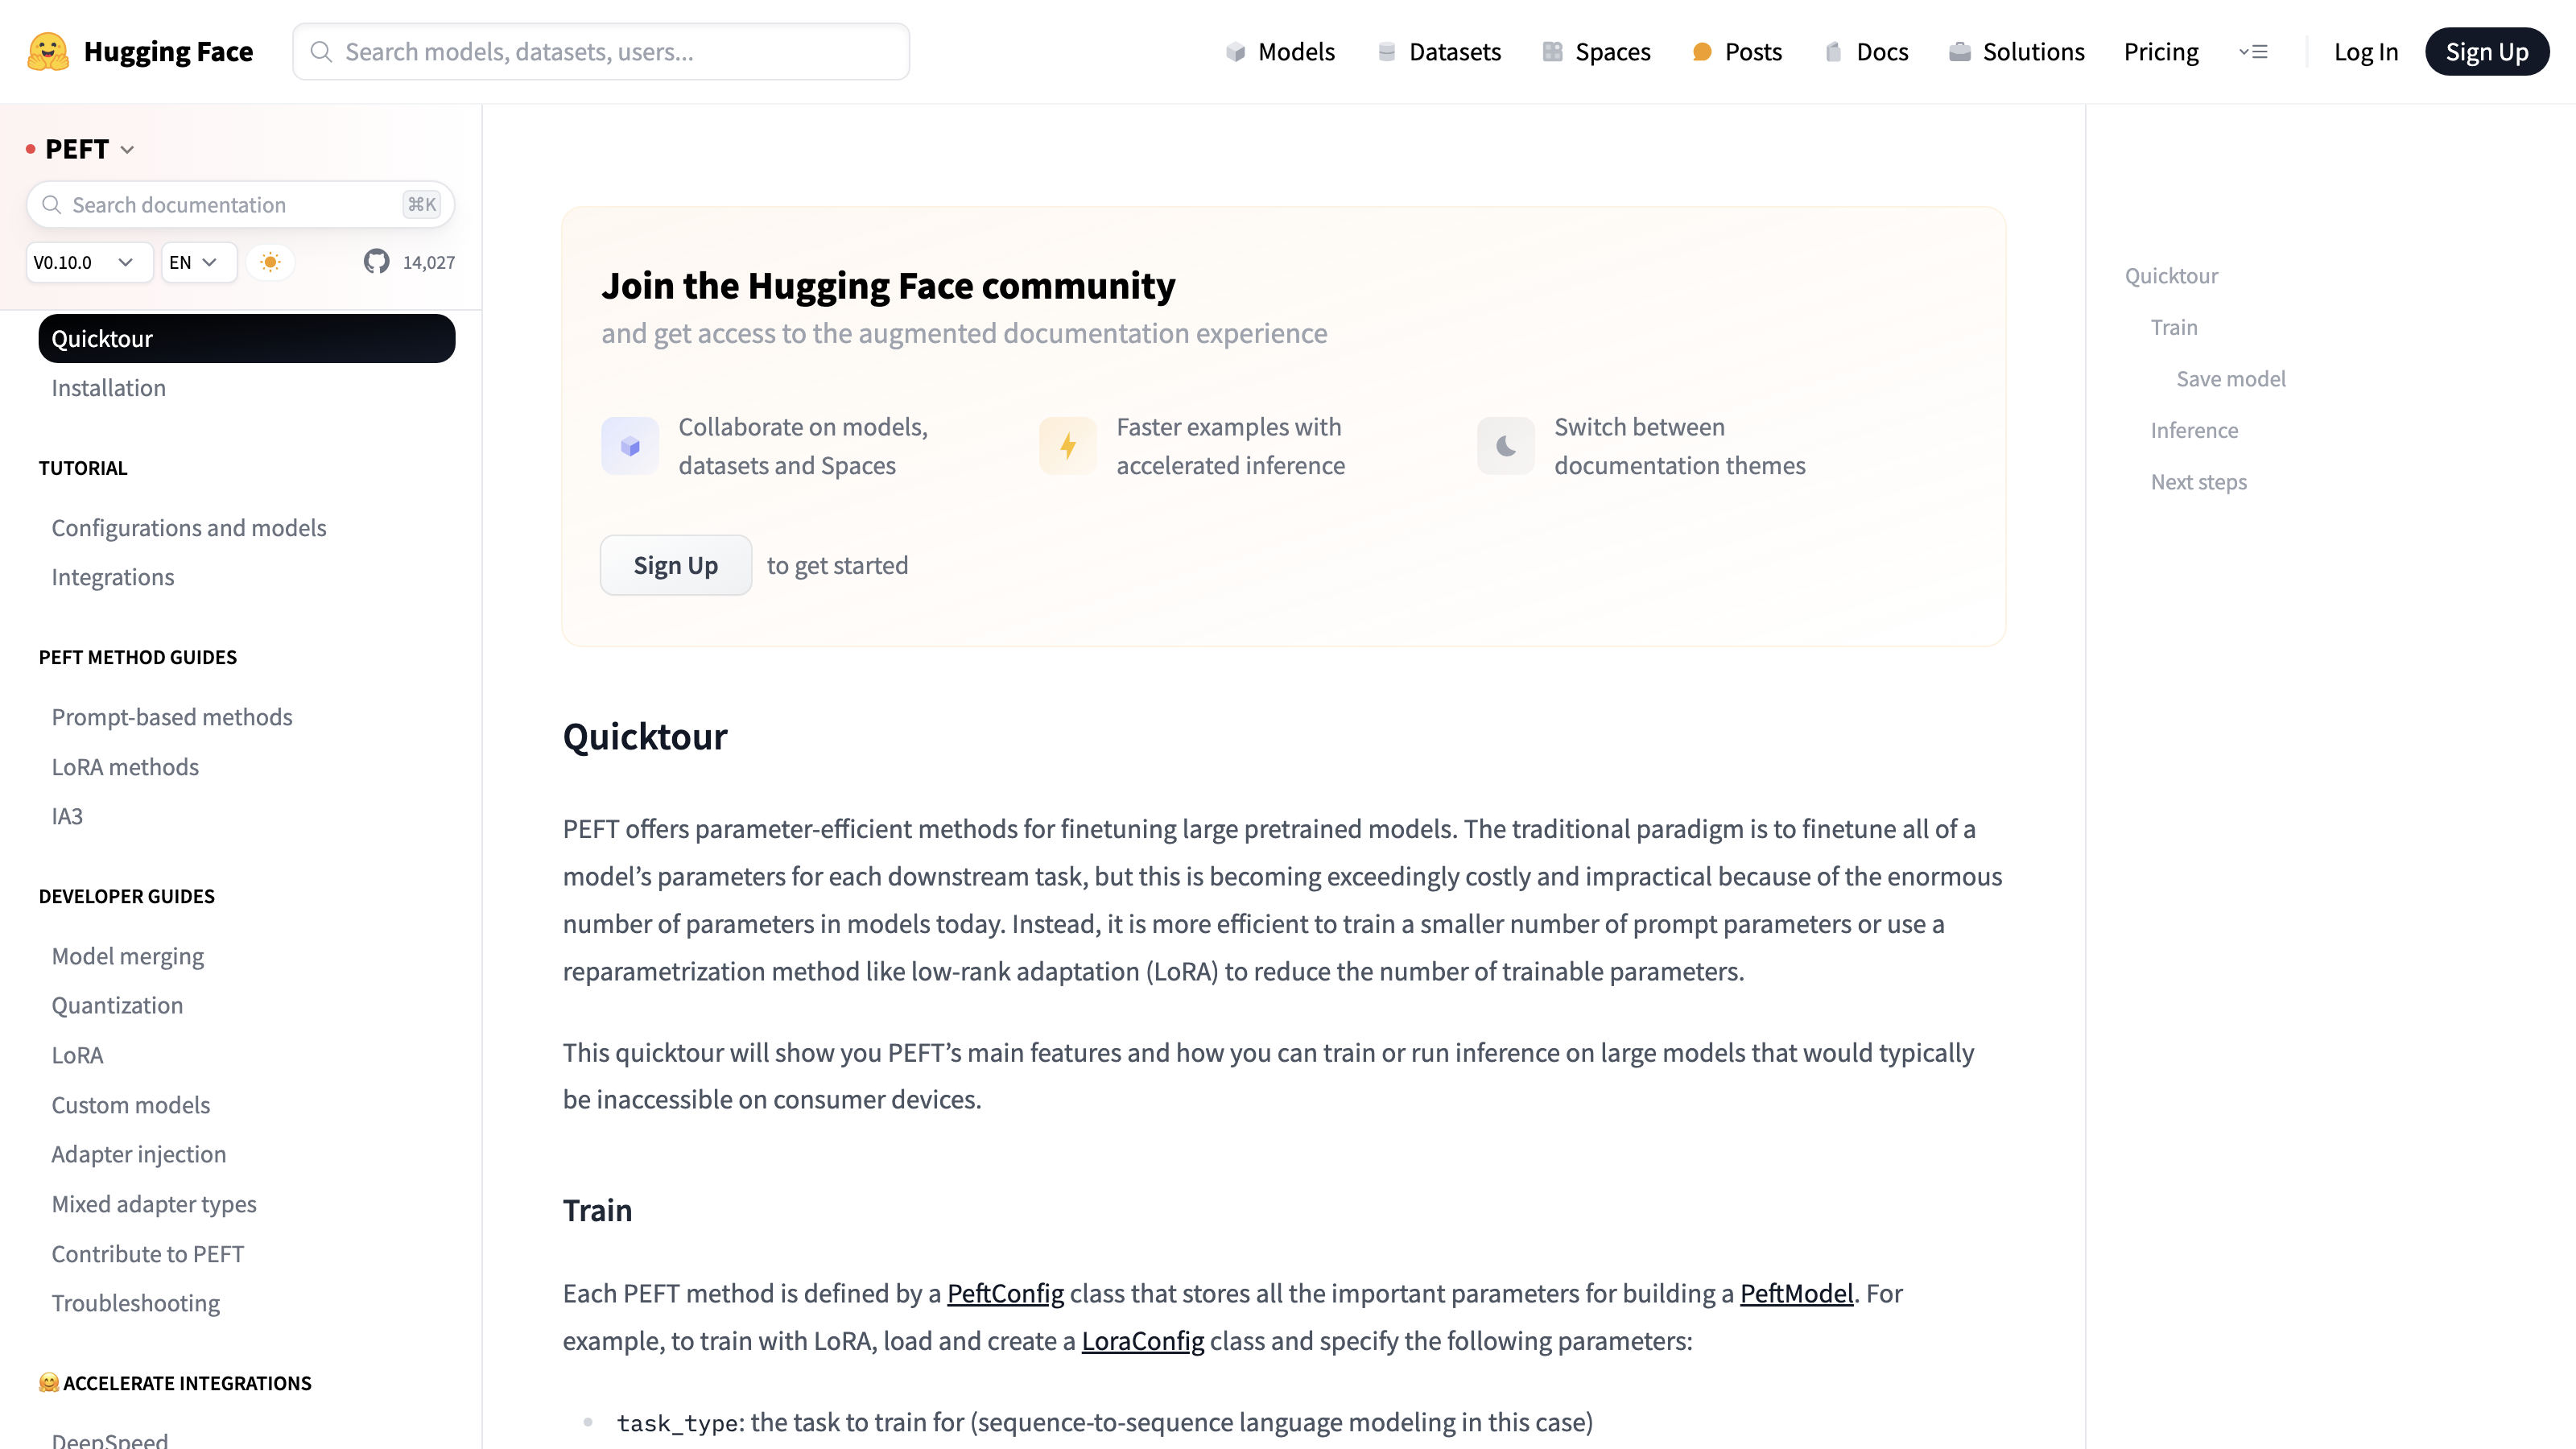

Computing an action plan...
Thoughts: Thoughts:
- The current screenshot shows the documentation page for PEFT on the Hugging Face website.
- The left sidebar clearly lists "Quicktour" as one of the options under the PEFT section.
- The main content area of the page is already displaying the "Quicktour" section, which includes subsections like Train, Save model, Inference, and Next steps.
- Since the objective is to go on the quicktour of PEFT and the page is already displaying the Quicktour content, no further navigation or action is required.

Instruction: STOP
Objective reached


In [7]:
from lavague.agents import WebAgent

agent = WebAgent(driver, action_engine, world_model)
agent.get("https://huggingface.co/docs")
agent.run("Go on the quicktour of PEFT")

In [8]:
print(action)

NameError: name 'action' is not defined

In [ ]:
from IPython.display import HTML, Code, display

for node in nodes:
    display(HTML(node))
    display(Code(node, language="html"))

<div class="group flex cursor-pointer items-center pl-2 text-[0.8rem] font-semibold uppercase leading-9 hover:text-gray-700 dark:hover:text-gray-300 ml-0"><div class="flex after:absolute after:right-4 after:text-gray-500 group-hover:after:content-['▶'] after:rotate-90 after:transform"><span><span class="inline-block space-x-1 leading-5"><span>Get started</span> </span></span></div></div> <div class="flex flex-col"><a class="rounded-xl bg-gradient-to-br from-black to-gray-900 py-1 pl-2 pr-2 text-white first:mt-1 last:mb-4 dark:from-gray-800 dark:to-gray-900 ml-2" href="/docs/peft/index" id="index">🤗 PEFT </a><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/quicktour" id="quicktour">Quicktour </a><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/install" id="install">Installation </a> </div><div class="group flex cursor-pointer items-center pl-2 text-[0.8rem] font-semibold uppercase leading-9 hover:text-gray-700 dark:hover:text-gray-300 ml-0"><div class="flex after:absolute after:right-4 after:text-gray-500 group-hover:after:content-['▶'] after:rotate-90 after:transform"><span><span class="inline-block space-x-1 leading-5"><span>Tutorial</span> </span></span></div></div> <div class="flex flex-col"><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/tutorial/peft_model_config" id="tutorial/peft_model_config">Configurations and models </a><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/tutorial/peft_integrations" id="tutorial/peft_integrations">Integrations </a> </div><div class="group flex cursor-pointer items-center pl-2 text-[0.8rem] font-semibold uppercase leading-9 hover:text-gray-700 dark:hover:text-gray-300 ml-0"><div class="flex after:absolute after:right-4 after:text-gray-500 group-hover:after:content-['▶'] after:rotate-90 after:transform"><span><span class="inline-block space-x-1 leading-5"><span>PEFT method guides</span> </span></span></div></div> <div class="flex flex-col"><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/task_guides/prompt_based_methods" id="task_guides/prompt_based_methods">Prompt-based methods </a><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/task_guides/lora_based_methods" id="task_guides/lora_based_methods">LoRA methods </a><a class="transform py-1 pl-2 pr-2 text-gray-500 first:mt-1 last:mb-4 hover:translate-x-px hover:text-black dark:hover:text-gray-300 ml-2" href="/docs/peft/task_guides/ia3" id="task_guides/ia3">IA3 </a> </div><div class="group flex cursor-pointer items-center pl-2 text-[0.8rem] font-semibold uppercase leading-9 hover:text-gray-700 dark:hover:text-gray-300 ml-0"><div class="flex after:absolute after:right-4 after:text-gray-500 group-hover:after:content-['▶'] after:rotate-90 after:transform"><span><span class="inline-block space-x-1 leading-5"><span>Developer guides</span> </span></span></div></div>

<div class="text-smd leading-tight text-gray-500 dark:text-gray-300 xl:max-w-[200px] 2xl:text-base">Switch between documentation themes
				</div></div></div>
		<div class="flex items-center space-x-2.5"><a href="/join"><button class="rounded-lg bg-white bg-gradient-to-br from-gray-100/20 to-gray-200/60 px-5 py-1.5 font-semibold text-gray-700 shadow-sm ring-1 ring-gray-300/60 hover:to-gray-100/70 hover:ring-gray-300/30 active:shadow-inner">Sign Up</button></a>
			<p class="text-gray-500 dark:text-gray-300">to get started</p></div></div></div>
				<div class="prose-doc prose relative mx-auto max-w-4xl break-words"> <p></p> <h1 class="relative group"><a id="peft" class="header-link block pr-1.5 text-lg no-hover:hidden with-hover:absolute with-hover:p-1.5 with-hover:opacity-0 with-hover:group-hover:opacity-100 with-hover:right-full" href="#peft"><span><svg class="" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 256 256"><path d="M167.594 88.393a8.001 8.001 0 0 1 0 11.314l-67.882 67.882a8 8 0 1 1-11.314-11.315l67.882-67.881a8.003 8.003 0 0 1 11.314 0zm-28.287 84.86l-28.284 28.284a40 40 0 0 1-56.567-56.567l28.284-28.284a8 8 0 0 0-11.315-11.315l-28.284 28.284a56 56 0 0 0 79.196 79.197l28.285-28.285a8 8 0 1 0-11.315-11.314zM212.852 43.14a56.002 56.002 0 0 0-79.196 0l-28.284 28.284a8 8 0 1 0 11.314 11.314l28.284-28.284a40 40 0 0 1 56.568 56.567l-28.285 28.285a8 8 0 0 0 11.315 11.314l28.284-28.284a56.065 56.065 0 0 0 0-79.196z" fill="currentColor"></path></svg></span></a> <span>PEFT</span></h1> <p data-svelte-h="svelte-cehkfa">🤗 PEFT (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model. This makes it more accessible to train and store large language models (LLMs) on consumer hardware.</p> <p data-svelte-h="svelte-n0kp74">PEFT is integrated with the Transformers, Diffusers, and Accelerate libraries to provide a faster and easier way to load, train, and use large models for inference.</p> <div class="mt-10" data-svelte-h="svelte-1ffe0tg"><div class="w-full flex flex-col space-y-4 md:space-y-0 md:grid md:grid-cols-2 md:gap-y-4 md:gap-x-5"><a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="quicktour"><div class="w-full text-center bg-gradient-to-br from-blue-400 to-blue-500 rounded-lg py-1.5 font-semibold mb-5 text-white text-lg leading-relaxed">Get started</div> <p class="text-gray-700">Start here if you're new to 🤗 PEFT to get an overview of the library's main features, and how to train a model with a PEFT method.</p></a> <a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="./task_guides/image_classification_lora"><div class="w-full text-center bg-gradient-to-br from-indigo-400 to-indigo-500 rounded-lg py-1.5 font-semibold mb-5 text-white text-lg leading-relaxed">How-to guides</div> <p class="text-gray-700">Practical guides demonstrating how to apply various PEFT methods across different types of tasks like image classification, causal language modeling, automatic speech recognition, and more. Learn how to use 🤗 PEFT with the DeepSpeed and Fully Sharded Data Parallel scripts.</p></a> <a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="./conceptual_guides/lora">

<div class="text-smd leading-tight text-gray-500 dark:text-gray-300 xl:max-w-[200px] 2xl:text-base">Switch between documentation themes
				</div></div></div>
		<div class="flex items-center space-x-2.5"><a href="/join"><button class="rounded-lg bg-white bg-gradient-to-br from-gray-100/20 to-gray-200/60 px-5 py-1.5 font-semibold text-gray-700 shadow-sm ring-1 ring-gray-300/60 hover:to-gray-100/70 hover:ring-gray-300/30 active:shadow-inner">Sign Up</button></a>
			<p class="text-gray-500 dark:text-gray-300">to get started</p></div></div></div>
				<div class="prose-doc prose relative mx-auto max-w-4xl break-words"> <p></p> <h1 class="relative group"><a id="peft" class="header-link block pr-1.5 text-lg no-hover:hidden with-hover:absolute with-hover:p-1.5 with-hover:opacity-0 with-hover:group-hover:opacity-100 with-hover:right-full" href="#peft"><span><svg class="" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 256 256"><path d="M167.594 88.393a8.001 8.001 0 0 1 0 11.314l-67.882 67.882a8 8 0 1 1-11.314-11.315l67.882-67.881a8.003 8.003 0 0 1 11.314 0zm-28.287 84.86l-28.284 28.284a40 40 0 0 1-56.567-56.567l28.284-28.284a8 8 0 0 0-11.315-11.315l-28.284 28.284a56 56 0 0 0 79.196 79.197l28.285-28.285a8 8 0 1 0-11.315-11.314zM212.852 43.14a56.002 56.002 0 0 0-79.196 0l-28.284 28.284a8 8 0 1 0 11.314 11.314l28.284-28.284a40 40 0 0 1 56.568 56.567l-28.285 28.285a8 8 0 0 0 11.315 11.314l28.284-28.284a56.065 56.065 0 0 0 0-79.196z" fill="currentColor"></path></svg></span></a> <span>PEFT</span></h1> <p data-svelte-h="svelte-cehkfa">🤗 PEFT (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model. This makes it more accessible to train and store large language models (LLMs) on consumer hardware.</p> <p data-svelte-h="svelte-n0kp74">PEFT is integrated with the Transformers, Diffusers, and Accelerate libraries to provide a faster and easier way to load, train, and use large models for inference.</p> <div class="mt-10" data-svelte-h="svelte-1ffe0tg"><div class="w-full flex flex-col space-y-4 md:space-y-0 md:grid md:grid-cols-2 md:gap-y-4 md:gap-x-5"><a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="quicktour"><div class="w-full text-center bg-gradient-to-br from-blue-400 to-blue-500 rounded-lg py-1.5 font-semibold mb-5 text-white text-lg leading-relaxed">Get started</div> <p class="text-gray-700">Start here if you're new to 🤗 PEFT to get an overview of the library's main features, and how to train a model with a PEFT method.</p></a> <a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="./task_guides/image_classification_lora"><div class="w-full text-center bg-gradient-to-br from-indigo-400 to-indigo-500 rounded-lg py-1.5 font-semibold mb-5 text-white text-lg leading-relaxed">How-to guides</div> <p class="text-gray-700">Practical guides demonstrating how to apply various PEFT methods across different types of tasks like image classification, causal language modeling, automatic speech recognition, and more. Learn how to use 🤗 PEFT with the DeepSpeed and Fully Sharded Data Parallel scripts.</p></a> <a class="!no-underline border dark:border-gray-700 p-5 rounded-lg shadow hover:shadow-lg" href="./conceptual_guides/lora">

In [ ]:
print("Response from the AI model:", response)

NameError: name 'response' is not defined

In [ ]:
model_link_xpath = """//article[.//header[contains(.,'Meta-Llama-3-8B')] and .//div[contains(.,'918k') and contains(.,'1 day ago')]]//a"""

# Now we can find the element using the XPath and click on it
model_link = driver.find_element(By.XPATH, model_link_xpath)
model_link.click()


<div class="flex items-center text-lg"><h1>Models</h1> <div class="ml-3 w-16 font-normal text-gray-400">649,031</div></div> <div class="flex-1 md:mx-4"><div class="relative w-full md:max-w-xs"><svg class="absolute left-2 top-1.5 text-gray-300 w-4" style="" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 24 24"><path class="uim-quaternary" d="M20.23 7.24L12 12L3.77 7.24a1.98 1.98 0 0 1 .7-.71L11 2.76c.62-.35 1.38-.35 2 0l6.53 3.77c.29.173.531.418.7.71z" opacity=".25" fill="currentColor"></path><path class="uim-tertiary" d="M12 12v9.5a2.09 2.09 0 0 1-.91-.21L4.5 17.48a2.003 2.003 0 0 1-1-1.73v-7.5a2.06 2.06 0 0 1 .27-1.01L12 12z" opacity=".5" fill="currentColor"></path><path class="uim-primary" d="M20.5 8.25v7.5a2.003 2.003 0 0 1-1 1.73l-6.62 3.82c-.275.13-.576.198-.88.2V12l8.23-4.76c.175.308.268.656.27 1.01z" fill="currentColor"></path></svg> <input class="w-full rounded-full border border-gray-200 text-sm placeholder-gray-400 shadow-inner outline-none focus:shadow-xl focus:ring-1 focus:ring-inset dark:bg-gray-950 h-7 pl-7" placeholder="Filter by name" type="search"></div></div> <a href="/search/full-text?type=model" class="btn mr-2 rounded-full text-sm opacity-80 hover:opacity-100">Full-text search</a> <div><button class="btn mr-2 inline-flex text-sm lg:hidden " type="button"><svg class="mr-1.5 " xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M18 28h-4a2 2 0 0 1-2-2v-7.59L4.59 11A2 2 0 0 1 4 9.59V6a2 2 0 0 1 2-2h20a2 2 0 0 1 2 2v3.59a2 2 0 0 1-.59 1.41L20 18.41V26a2 2 0 0 1-2 2zM6 6v3.59l8 8V26h4v-8.41l8-8V6z"></path></svg> Add filters</button> <div class="relative inline-block"><button class=" btn w-full cursor-pointer text-sm" type="button"><svg class="mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32"><path d="M27.6 20.6L24 24.2V4h-2v20.2l-3.6-3.6L17 22l6 6l6-6z" fill="currentColor"></path><path d="M9 4l-6 6l1.4 1.4L8 7.8V28h2V7.8l3.6 3.6L15 10z" fill="currentColor"></path></svg>
		Sort:&nbsp;
		Trending </button> </div></div></div>  <div class="relative"><div class="grid grid-cols-1 gap-5 2xl:grid-cols-2"><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/meta-llama/Meta-Llama-3-8B"><header class="flex items-center mb-0.5" title="meta-llama/Meta-Llama-3-8B"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/646cf8084eefb026fb8fd8bc/oCTqufkdTkjyGodsx1vo1.png" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">meta-llama/Meta-Llama-3-8B</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-09T19:47:40" title="Thu, 09 May 2024 19:47:40 GMT">1 day ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 918k <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 3.59k </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/nvidia/Llama3-ChatQA-1.5-8B"><header class="flex items-center mb-0.5" title="nvidia/Llama3-ChatQA-1.5-8B"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/1613114437487-60262a8e0703121c822a80b6.png" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">nvidia/Llama3-ChatQA-1.5-8B</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-09T06:33:18" title="Thu, 09 May 2024 06:33:18 GMT">2 days ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 25k <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 239 </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/meta-llama/Meta-Llama-3-8B-Instruct"><header class="flex items-center mb-0.5" title="meta-llama/Meta-Llama-3-8B-Instruct"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/646cf8084eefb026fb8fd8bc/oCTqufkdTkjyGodsx1vo1.png" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">meta-llama/Meta-Llama-3-8B-Instruct</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-10T06:24:30" title="Fri, 10 May 2024 06:24:30 GMT">1 day ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 1.65M <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 1.99k </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/apple/OpenELM"><header class="flex items-center mb-0.5" title="apple/OpenELM"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/1653390727490-5dd96eb166059660ed1ee413.jpeg" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">apple/OpenELM</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-09T20:42:29" title="Thu, 09 May 2024 20:42:29 GMT">1 day ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 349 <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 77 </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/meta-llama/Meta-Llama-3-70B-Instruct"><header class="flex items-center mb-0.5" title="meta-llama/Meta-Llama-3-70B-Instruct"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/646cf8084eefb026fb8fd8bc/oCTqufkdTkjyGodsx1vo1.png" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">meta-llama/Meta-Llama-3-70B-Instruct</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-10T06:26:30" title="Fri, 10 May 2024 06:26:30 GMT">1 day ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 296k <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 927 </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/mistralai/Mistral-7B-Instruct-v0.2"><header class="flex items-center mb-0.5" title="mistralai/Mistral-7B-Instruct-v0.2"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://cdn-avatars.huggingface.co/v1/production/uploads/62dac1c7a8ead43d20e3e17a/wrLf5yaGC6ng4XME70w6Z.png" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">mistralai/Mistral-7B-Instruct-v0.2</h4> </header>

<div class="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400"><svg class="mr-1.5 text-[.8rem]" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" fill="currentColor" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 18 18"><path d="M16.2607 8.08202L14.468 6.28928C14.3063 6.12804 14.0873 6.03749 13.859 6.03749C13.6307 6.03749 13.4117 6.12804 13.25 6.28928L5.6375 13.904V16.9125H8.64607L16.2607 9.30002C16.422 9.13836 16.5125 8.91935 16.5125 8.69102C16.5125 8.4627 16.422 8.24369 16.2607 8.08202V8.08202ZM8.1953 15.825H6.725V14.3547L11.858 9.22118L13.3288 10.6915L8.1953 15.825ZM14.0982 9.92262L12.6279 8.45232L13.8606 7.21964L15.3309 8.68994L14.0982 9.92262Z"></path><path d="M6.18125 9.84373H7.26875V6.03748H8.9V4.94998H4.55V6.03748H6.18125V9.84373Z"></path><path d="M4.55 11.475H2.375V2.775H11.075V4.95H12.1625V2.775C12.1625 2.48658 12.0479 2.20997 11.844 2.00602C11.64 1.80208 11.3634 1.6875 11.075 1.6875H2.375C2.08658 1.6875 1.80997 1.80208 1.60602 2.00602C1.40207 2.20997 1.2875 2.48658 1.2875 2.775V11.475C1.2875 11.7634 1.40207 12.04 1.60602 12.244C1.80997 12.4479 2.08658 12.5625 2.375 12.5625H4.55V11.475Z"></path></svg> Text Generation <span class="px-1.5 text-gray-300">•</span> <span class="truncate">Updated
				<time datetime="2024-05-10T06:14:47" title="Fri, 10 May 2024 06:14:47 GMT">1 day ago</time></span> <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-0.5" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" viewBox="0 0 32 32"><path fill="currentColor" d="M26 24v4H6v-4H4v4a2 2 0 0 0 2 2h20a2 2 0 0 0 2-2v-4zm0-10l-1.41-1.41L17 20.17V2h-2v18.17l-7.59-7.58L6 14l10 10l10-10z"></path></svg> 3.21k <span class="px-1.5 text-gray-300">•</span> <svg class="flex-none w-3 text-gray-400 mr-1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" aria-hidden="true" focusable="false" role="img" width="1em" height="1em" preserveAspectRatio="xMidYMid meet" viewBox="0 0 32 32" fill="currentColor"><path d="M22.45,6a5.47,5.47,0,0,1,3.91,1.64,5.7,5.7,0,0,1,0,8L16,26.13,5.64,15.64a5.7,5.7,0,0,1,0-8,5.48,5.48,0,0,1,7.82,0L16,10.24l2.53-2.58A5.44,5.44,0,0,1,22.45,6m0-2a7.47,7.47,0,0,0-5.34,2.24L16,7.36,14.89,6.24a7.49,7.49,0,0,0-10.68,0,7.72,7.72,0,0,0,0,10.82L16,29,27.79,17.06a7.72,7.72,0,0,0,0-10.82A7.49,7.49,0,0,0,22.45,4Z"></path></svg> 56 </div></a></article><article class="overview-card-wrapper group/repo  "><a class="block p-2" href="/Fugaku-LLM/Fugaku-LLM-13B"><header class="flex items-center mb-0.5" title="Fugaku-LLM/Fugaku-LLM-13B"><img alt="" class="w-3.5 h-3.5 rounded mr-1.5 flex-none flex-none" src="https://www.gravatar.com/avatar/710c6b0882d4011d91b495b10ad8777e?d=retro&amp;size=100" crossorigin="anonymous"> <h4 class="text-md truncate font-mono text-black dark:group-hover/repo:text-yellow-500 group-hover/repo:text-indigo-600 text-smd">Fugaku-LLM/Fugaku-LLM-13B</h4> </header>

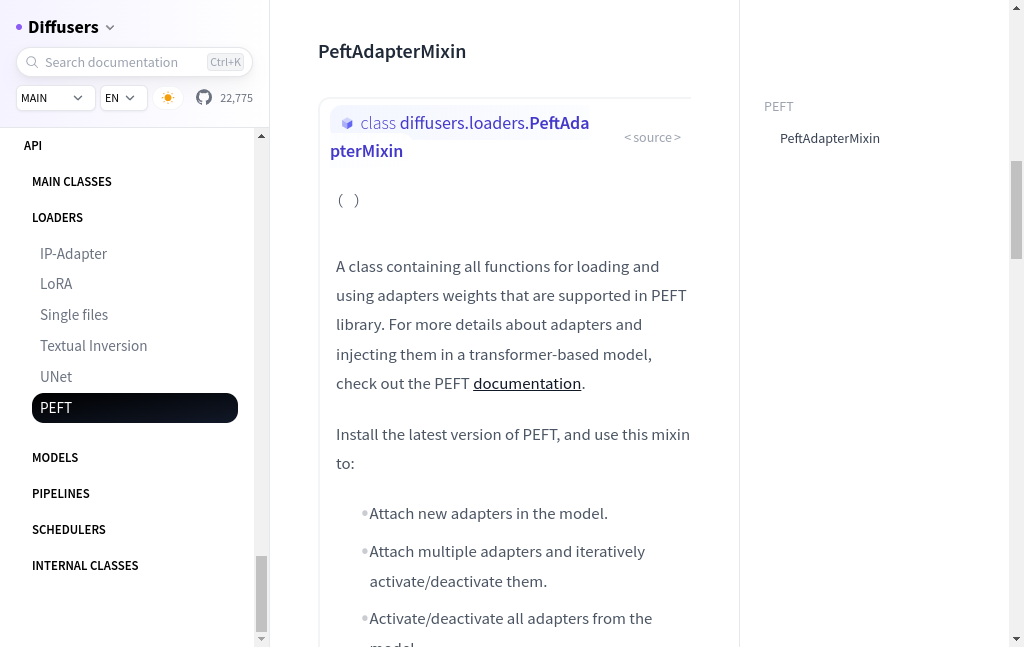

Computing an action plan...
Thoughts: Thoughts:
- The current screenshot shows the documentation page for the Diffusers library on the Hugging Face website.
- The left sidebar lists various sections of the documentation, including "PEFT" which is highlighted, indicating that the current view is focused on this section.
- The main content area provides detailed information about a class named `PefAdapterMixin` which is part of the PEFT section.
- The objective is to go on the quick tour of PEFT, which suggests looking for a general overview or introductory section rather than detailed class information.
- The quick tour might be located in a more introductory or summary section of the PEFT documentation.

Instruction: Click on the 'PEFT' section in the left sidebar to access the general overview or introductory content of PEFT.
Action execution failed. Retrying...


KeyboardInterrupt: 

In [ ]:
import time
from IPython.display import clear_output, display, Image
from lavague.web_utils import get_highlighted_element, display_screenshot, encode_image
from lavague.format_utils import extract_instruction

objective = "Go on the quicktour of PEFT"

driver.get("https://huggingface.co/docs")
N_ATTEMPTS = 10
N_STEPS = 5

driver.save_screenshot("screenshot.png")
display(Image("screenshot.png"))

print("Objective: ", objective)

for i in range(N_STEPS):
    print("Computing an action plan...")
    
    # We get the current screenshot into base64 before sending to our World Model
    state = encode_image("screenshot.png")
    
    # We get the instruction for the action engine using the world model
    output = world_model.get_instruction(state, objective)
    instruction = extract_instruction(output)
    
    print("Thoughts:", output)
    if instruction != "STOP":
        query = instruction
        html = driver.page_source

        # We retrieve once the parts of the HTML that are relevant for the action generation, in case of we have to retry several times
        nodes = action_engine.get_nodes(query, html)
        context = "\n".join(nodes)
        for _ in range(N_ATTEMPTS):
            try:
                action = action_engine.action_from_context(context, query)
                screenshot_before_action = get_highlighted_element(action, driver)
                clear_output()
                display(screenshot_before_action)
                print("Showing the next element to interact with")
                time.sleep(3)

                exec(action)
                time.sleep(3)
                clear_output()
                display_screenshot(driver)
                break

            except Exception as e:
                print("Action execution failed. Retrying...")
                pass
    else:
        print("Objective reached")
        break